# Knowledge Graph for Medium Blogs

## Workspace Setup

In [1]:
import pandas as pd
import numpy as np
#import json
#from datetime import datetime

# useful pandas settings

# Use 2 decimal places in the output display
pd.set_option("display.precision", 2)

# Don't wrap dataframe across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set the maximum widths of columns
pd.set_option("display.max_colwidth", 120)

# Set max rows displayed in output to 20
pd.set_option("display.max_rows", 20)

In [2]:
# Import visualization packages and libraries

import pprint
#import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

## Upload Data

In [3]:
# Upload blogs-authors dataset with cluster information
df_blogs = pd.read_csv('data/data_processed/corpus_clusters.csv')
df_blogs.head(2)

,user_id,date,reading_time,title,subtitle,claps,responses,story_url,year,month,day,story_id,corpus,hard_labels,soft_labels
0,e9ee1187182a,2021-03-01,4,Stop using numpy.random.seed(),How to set random seeds for individual classes in Python,150,1,https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f?source=collection_archive---------0--------...,2021,3,1,581a9972805f,Stop using numpy.random.seed() How to set random seeds for individual classes in Python,34,26
1,fa1913854e95,2021-03-01,11,Semi-Automated Exploratory Data Analysis (EDA) in Python,Comprehensive Data Exploration Process with…,1000,8,https://towardsdatascience.com/semi-automated-exploratory-data-analysis-eda-in-python-7f96042c9809?source=collection...,2021,3,1,7f96042c9809,Semi-Automated Exploratory Data Analysis (EDA) in Python Comprehensive Data Exploration Process with…,65,72


In [4]:
# Upload metadata with linked entities
df_meta = pd.read_csv('data/data_processed/corpus_metadata.csv')
df_meta.head(2)

,soft_labels,key1,key2,key3,key4,key5,meta_key1_description,meta_key1_wid,meta_key1_wikilabel,meta_key2_description,...,meta_key2_wikilabel,meta_key3_description,meta_key3_wid,meta_key3_wikilabel,meta_key4_description,meta_key4_wid,meta_key4_wikilabel,meta_key5_description,meta_key5_wid,meta_key5_wikilabel
0,0,science improving coffee grind distribution,espresso shot coffee particle distribution coffee data,small sample espresso filter comparison,tds coffee data,staccato espresso,study and knowledge of the natural world; the natural and social sciences,336,science,brewed beverage prepared from roasted coffee seeds,...,coffee,A kind of coffee,180289,espresso,brewed beverage prepared from roasted coffee seeds,8486,coffee,form of musical articulation,466944,staccato
1,1,quantum computing learn,understanding grover,qubits means,encrypted data,mechanical properties,theoretical computation device relying on quantum mechanics,176555,quantum computer,American basketball player,...,Tim Hardaway Jr.,"unit of quantum information, analogous to the classical bit; the information carried by a 2-state quantum-mechanical...",378201,qubit,facts represented for handling,42848,data,"physical or intangible entity, owned by a person or a group of people",6422240,property


In [5]:
# Fill in the missing values to avoid Neo4j errors
df_meta_filled = df_meta.replace(np.nan, '', regex=True)

## Establish Neo4j Connection

In [3]:
# Initialize a Neo4j Desktop session - must have a running DBMS
# On create install APOC and GDS library

from neo4j import GraphDatabase
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'mediumdata'))

In [4]:
# Function to parse Cypher queries
def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

## Create Knowledge Graph

In [5]:
# Create uniqueness constraints
with driver.session() as session:
    session.run('CREATE CONSTRAINT blogs IF NOT EXISTS FOR (b:Blog) REQUIRE b.story_id IS UNIQUE;')
    session.run('CREATE CONSTRAINT authors IF NOT EXISTS FOR (a:Author) REQUIRE a.user_id IS UNIQUE;')
    session.run('CREATE CONSTRAINT topics IF NOT EXISTS FOR (c:Cluster) REQUIRE c.soft_labels IS UNIQUE;')

In [ ]:
# Import data

import_query = """

UNWIND $data as row
MERGE (b:Blog {bid: row['id']})
ON CREATE SET b.title = row['title']
ON CREATE SET b.subtitle = row['subtitle']
ON CREATE SET b.date = date(row['date'])
ON CREATE SET b.claps = row['claps']
ON CREATE SET b.readtime = row['reading_time']
ON CREATE SET b.labels = row['labels']

MERGE (a:Author {name: row['author']})
MERGE (a)-[:WROTE]->(b)
"""

import_data = []
session = driver.session()
for i, row in df_blogs.iterrows():
    import_data.append({'id':row['story_id'], 
                        'title':row['title'], 
                        'subtitle':row['subtitle'], 
                        'date':row['date'],
                        'author':row['user_id'],
                        'reading_time': row['reading_time'],
                        'claps': row['claps'],
                        'labels': row['soft_labels']})
    if ((i % 2000) == 0) and (len(import_data) != 0):
        session.run(import_query, {'data':import_data})
        import_data = []

session.run(import_query, {'data':import_data})
session.close()

In [ ]:
# Rename the labels property to topic property

data = read_query('''
MATCH (b:Blog)
WITH collect(b) AS blogs
CALL apoc.refactor.rename.nodeProperty("labels", "topic", blogs)
YIELD committedOperations
RETURN committedOperations
''')

In [ ]:
# Refactor the property topic to a node Cluster and connect it to the Blog node

data = read_query("""
MATCH (b:Blog)
WITH b, b.topic as topnumber
MATCH (b:Blog {topic: topnumber})
MERGE (c:Cluster {topic: topnumber})
MERGE (b) - [:HAS_TOPIC] -> (c)
RETURN count(c)
""")

In [ ]:
# Import linked data

import_query = """

UNWIND $data as row
MERGE (t:Cluster {topic: row['topic']})
SET t.key1 = row['key1']
SET t.description1 = row['description1']
SET t.wid1 = row['wid1']
SET t.wikilabel1 = row['wikilabel1']
SET t.key2 = row['key2']
SET t.description2 = row['description2']
SET t.wid2 = row['wid2']
SET t.wikilabel2 = row['wikilabel2']
SET t.key3 = row['key3']
SET t.description3 = row['description3']
SET t.wid3 = row['wid3']
SET t.wikilabel3 = row['wikilabel3']
SET t.key4 = row['key4']
SET t.description4 = row['description4']
SET t.wid4 = row['wid4']
SET t.wikilabel4 = row['wikilabel4']
SET t.key5 = row['key5']
SET t.description5 = row['description5']
SET t.wid5 = row['wid5']
SET t.wikilabel5 = row['wikilabel5']
RETURN count(t)
"""

import_data = []
session = driver.session()
for i, row in df_meta_filled.iterrows():
    import_data.append({'topic':row['soft_labels'], 
                        'key1':row['key1'], 'description1':row['meta_key1_description'], 
                        'wid1': row['meta_key1_wid'], 'wikilabel1': row['meta_key1_wikilabel'],
                        'key2':row['key2'], 'description2':row['meta_key2_description'], 
                        'wid2': row['meta_key2_wid'], 'wikilabel2': row['meta_key2_wikilabel'],
                        'key3':row['key3'], 'description3':row['meta_key3_description'], 
                        'wid3': row['meta_key3_wid'], 'wikilabel3': row['meta_key3_wikilabel'],
                        'key4':row['key4'], 'description4':row['meta_key4_description'], 
                        'wid4': row['meta_key4_wid'], 'wikilabel4': row['meta_key4_wikilabel'],
                        'key5':row['key5'], 'description5':row['meta_key5_description'], 
                        'wid5': row['meta_key5_wid'], 'wikilabel5': row['meta_key5_wikilabel']})
session.run(import_query, {'data':import_data})
session.close()

## Graph Data Exploration

In [19]:
# Display graph information

data = read_query('''
CALL apoc.meta.stats()
YIELD nodeCount, relCount,
      propertyKeyCount,
      labelCount, labels,
      relTypeCount, relTypes
RETURN nodeCount, relCount,
    propertyKeyCount,
    labelCount, labels,
    relTypeCount, relTypes;
    ''')

In [21]:
data.labels

0    {'Author': 12044, 'Cluster': 143, 'Blog': 51762}
Name: labels, dtype: object

In [8]:
data.relTypes

0    {'()-[:WROTE]->()': 51762, '()-[:WROTE]->(:Blog)': 51762, '()-[:HAS_TOPIC]->(:Cluster)': 51762, '(:Author)-[:WROTE]-...
Name: relTypes, dtype: object

In [9]:
# Extract information about the graph schema
data = read_query('''CALL apoc.meta.schema()
YIELD value
UNWIND keys(value) AS key
RETURN key, value[key] AS value;''')
data

,key,value
0,HAS_TOPIC,"{'count': 51762, 'type': 'relationship', 'properties': {}}"
1,Author,"{'relationships': {'WROTE': {'count': 0, 'properties': {}, 'direction': 'out', 'labels': ['Blog']}}, 'count': 12044,..."
2,Cluster,"{'relationships': {'HAS_TOPIC': {'count': 995, 'properties': {}, 'direction': 'in', 'labels': ['Blog']}}, 'count': 1..."
3,Blog,"{'relationships': {'WROTE': {'count': 4100, 'properties': {}, 'direction': 'in', 'labels': ['Author']}, 'HAS_TOPIC':..."
4,WROTE,"{'count': 51762, 'type': 'relationship', 'properties': {}}"


In [30]:
# Get properties for the node Cluster
data = read_query('''
MATCH (c:Cluster)
            RETURN keys(c)
            LIMIT 1;
''')
print(list(data.iloc[0]))

[['pagerank_cotopics', 'description5', 'wid5', 'wikilabel5', 'wcc_cotopic', 'wid4', 'wikilabel4', 'key5', 'key4', 'description3', 'wid3', 'wikilabel3', 'description4', 'wikilabel2', 'key3', 'key2', 'wid2', 'wid1', 'wikilabel1', 'description2', 'description1', 'topic', 'key1']]


In [31]:
# Get properties for the node Blog
data = read_query('''
MATCH (b:Blog)
            RETURN keys(b)
            LIMIT 1;
''')
print(data)

                                                keys(b)
0  [date, claps, readtime, topic, bid, title, subtitle]


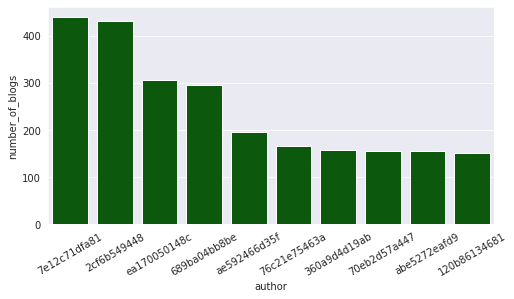

In [32]:
# Find the most prolific authors
data = read_query("""
MATCH (a:Author)
RETURN a.name AS author, apoc.node.degree(a) AS number_of_blogs
ORDER BY number_of_blogs DESC LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="author", y="number_of_blogs", data=data, color="darkgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

There are two authors that have more than 400 blogs each. Let's learn more about them.

In [33]:
author0 = data.author[0]
author1 = data.author[1]
author0, author1

('7e12c71dfa81', '2cf6b549448')

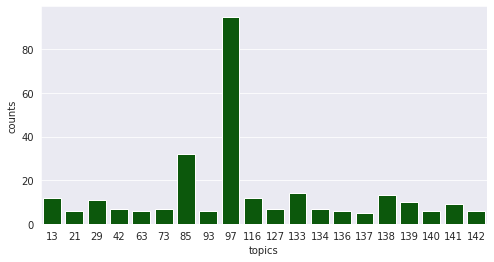

In [36]:
# Find topics for the most prolific author
data = read_query("""
MATCH (a:Author {name : '7e12c71dfa81'})-[]-(b:Blog)
RETURN b.topic AS topics, count(*) as counts
ORDER BY counts DESC
LIMIT 20
""")

fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="topics", y="counts", data=data, 
                 color="darkgreen")

In [38]:
data.head()

,topics,counts
0,97,95
1,85,32
2,133,14
3,138,13
4,116,12


In [39]:
# Take a look at several articles in topic 97
data = read_query("""
MATCH (a:Author {name :'7e12c71dfa81'})-[]-(b:Blog {topic:97}) -[]-(c:Cluster)
RETURN b.title AS title, b.subtitle AS subtitle, b.topic AS label, c.key1 AS topic1,
c.key2 AS topic2, c.key3 AS topic3
LIMIT 5
""")
data

,title,subtitle,label,topic1,topic2,topic3
0,Can Big Data Tell Human Stories?,Our weekly selection of must-read Editors’ Picks and original…,97,weekly data science,data journalism knowledge,ai blogs
1,The 2022 Data Science Articles You (Absolutely) Shouldn’t Miss,-,97,weekly data science,data journalism knowledge,ai blogs
2,5 Popular Posts on Making Your Life as a Data Scientist Easier,From speeding up your loading time to…,97,weekly data science,data journalism knowledge,ai blogs
3,’Tis the Season to Explore our Best Deep Dives,Our weekly selection of must-read Editors’ Picks and…,97,weekly data science,data journalism knowledge,ai blogs
4,December Edition: 2022 Highlights,Monthly Edition,97,weekly data science,data journalism knowledge,ai blogs


In [40]:
# Take a look at several articles in topic 85
data = read_query("""
MATCH (a:Author {name :'7e12c71dfa81'})-[]-(b:Blog {topic:85})-[]-(c:Cluster)
RETURN b.title AS title, b.topic AS label, c.key1 AS topic1, c.key2 AS topic2
LIMIT 5
""")
data

,title,label,topic1,topic2
0,Data Skills Can Make a Big Difference in Non-Data-Science Careers,85,data science blogging,irresistible data science resume
1,"To Make an Impact in Any Industry, Domain Knowledge Is Critical",85,data science blogging,irresistible data science resume
2,August Edition: Writing Better as a Data Scientist,85,data science blogging,irresistible data science resume
3,"Sara Metwalli on NLP, Public Writing, and Launching a Data Science Career",85,data science blogging,irresistible data science resume
4,The Right Skill Set Is the One That Allows You to Pursue Your Interests,85,data science blogging,irresistible data science resume


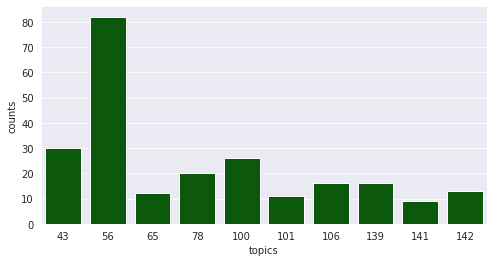

In [41]:
# Find topics for the second most prolific author
data = read_query("""
MATCH (a:Author {name : '2cf6b549448'})-[]-(b:Blog)
RETURN b.topic AS topics, count(*) as counts
ORDER BY counts DESC LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="topics", y="counts", data=data, color="darkgreen")

In [42]:
# Take a look at several articles in topic 56
# Find topics for the most prolific author
data = read_query("""
MATCH (a:Author {name :'2cf6b549448'})-[]-(b:Blog {topic:56})-[]-(c:Cluster)
RETURN b.title AS title, c.key1 as topic1
LIMIT 5
""")
data

,title,topic1
0,2 Different Replace Functions of Python Pandas,faster pandas operations
1,4 Techniques for Scaling Pandas to Large Datasets,faster pandas operations
2,Data Visualization with Pandas,faster pandas operations
3,5 Methods for Filtering Strings with Python Pandas,faster pandas operations
4,Pandas May Not Be the King of the Jungle After All,faster pandas operations


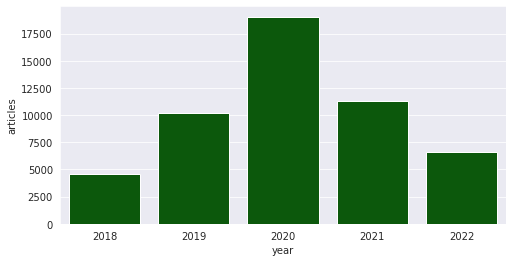

In [43]:
# Blogs written by year
data = read_query("""
MATCH (b:Blog)
RETURN b.date.year as year, count(*) as articles
ORDER BY year
""")
fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="year", y="articles", data=data, color="darkgreen")

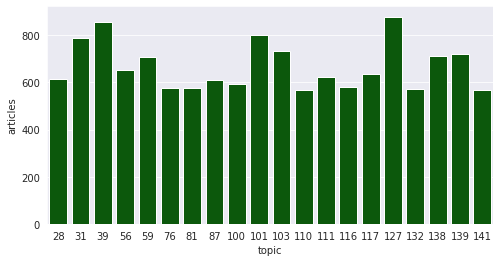

In [44]:
# Blogs written by topic
data = read_query("""
MATCH (b:Blog)
RETURN b.topic as topic, count(*) as articles
ORDER BY articles 
DESC LIMIT 20 
""")
fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="topic", y="articles", data=data, color="darkgreen")

In [46]:
# The most popular topics
data.head()

,topic,articles
0,127,879
1,39,856
2,101,801
3,31,787
4,103,735


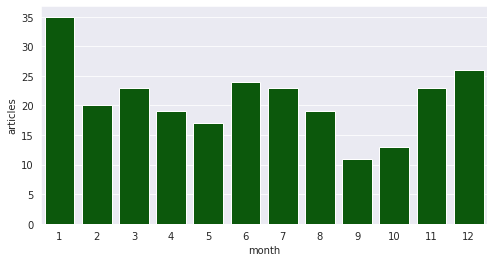

In [47]:
# The distribution of the most popular topic 127 over the months of 2020
data = read_query("""
MATCH (b:Blog)
WHERE b.topic = 127 AND b.date.year=2020
RETURN b.date.month as month, count(*) as articles
""")
fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="month", y="articles", data=data, color="darkgreen")

In [48]:
# Retrieve some information about the most numerous topic
data = read_query("""
MATCH (c:Cluster)
WHERE c.topic = 127 
RETURN c.key1 AS key1, c.description1 AS description1,
c.key2 AS key2, c.description2 AS description2,
c.key3 AS key3, c.description3 AS description3,
c.key4 AS key4, c.description4 AS description4
""")
data.T

,0
key1,ai ethics
description1,"branch of philosophy that systematizes, defends, and recommends concepts of right and wrong conduct"
key2,old cybernetics questions
description2,theory of communication and control based on regulatory feedback
key3,choices opensource
description3,act of choosing from multiple options
key4,crisis bridging social science
description4,type of event that is a unstable and dangerous situation


In [50]:
# Some titles in the most popular topic 127
data = read_query("""
MATCH (b:Blog)
WHERE b.topic = 127 
RETURN b.title AS title, b.date AS date
ORDER BY date DESC LIMIT 20
""")
data

,title,date
0,The Struggle to Advance Artificial Intelligence (AI) in the European Healthcare and…,2022-12-18
1,A New Spin to Ethical AI: Trolley Problems with GPT-3,2022-11-30
2,Galactica: What Dangerous AI Looks Like,2022-11-22
3,How Generative AI will Disrupt Everything During the Current Decade,2022-11-10
4,"AI Scaling: Why Keeping Up Is Essential, And How To Do It",2022-11-08
5,"A new, old lens on AI and its implications for IP disputes",2022-11-07
6,On AI Governance: How to Get Started,2022-10-28
7,How Assistance Games make AI safer,2022-10-26
8,"Towards Data Science Podcast Finale: The future of AI, and the risks that come with it",2022-10-19
9,AI Alignment and Totalitarianism,2022-10-15


In [51]:
# All articles written on a specific date
data = read_query("""
MATCH (b:Blog)-[]-(a:Author)
WHERE b.date = date("2022-11-22") 
RETURN b.title as title, b.topic as topic, a.name as author
ORDER BY topic
""")
data

,title,topic,author
0,"2022 World Cup Simulator Using Data Science, with Python",6,254e653181d2
1,Identify Data Loading Bottlenecks in Power BI,17,64005b7daa38
2,Every Scaler and Its Application in Data Science,23,ea170050148c
3,A New Era of Massively Parallel Simulation: A Practical Tutorial Using ElegantRL,26,df236586b4f5
4,Gentle Introduction to TensorFlow Probability — Trainable Parameters,27,2195f049db86
...,...,...,...
34,Top 5 Benchmark Datasets,123,120b86134681
35,Galactica: What Dangerous AI Looks Like,127,7ba6be8a3022
36,What I Learned in My First 6 Months as a Director of Data Science,136,a9bc11f7a61b
37,The Obscure Art of Data Design,138,2fccb851bb5e


In [52]:
# Most active writers by month in 2020

data = read_query("""
MATCH (a:Author)-[:WROTE]->(b:Blog)
WHERE b.date.year = 2020 
WITH b.date.month as month, a.name as author, count(*) as blogs
ORDER BY blogs DESC
RETURN month, collect(author)[..5] as most_active_writers
ORDER BY month
""")
data

,month,most_active_writers
0,1,"[ca32a96e6dc7, 360a9d4d19ab, 120b86134681, 689ba04bb8be, 26a3909adc91]"
1,2,"[84a02493194a, ea170050148c, 2cf6b549448, 57de827b2dd, 964fe0870229]"
2,3,"[120b86134681, be743a65b006, 8002c1aed6e7, 593908e0206, 360a9d4d19ab]"
3,4,"[97c118547987, 2cf6b549448, 360a9d4d19ab, 120b86134681, 7b5b79d21508]"
4,5,"[2cf6b549448, ea170050148c, 97c118547987, 120b86134681, b9d77a4ca1d1]"
5,6,"[2cf6b549448, be743a65b006, b1444918afee, abe5272eafd9, 88797ba3f2f6]"
6,7,"[b1444918afee, 7e12c71dfa81, 5b8617eb89bb, 2cf6b549448, abe5272eafd9]"
7,8,"[b1444918afee, 2cf6b549448, 7e12c71dfa81, df006e67e544, eec017a8b178]"
8,9,"[2cf6b549448, 7e12c71dfa81, 6863335d05f7, 120b86134681, ea170050148c]"
9,10,"[2cf6b549448, 7e12c71dfa81, 2b0fa005e971, ea170050148c, 689ba04bb8be]"


## Cluster Relation Analysis

In [53]:
# Create the graph projection that takes into account relations between topics
read_query("""
CALL gds.graph.project.cypher('cotopic-network',
  'MATCH (c:Cluster) RETURN id(c) as id',
  'MATCH (s:Cluster)-[]-()<-[:WROTE]-(a:Author)-[:WROTE]->()-[]-(t:Cluster)
   RETURN id(s) as source, id(t) as target, count(*) as weight')
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,projectMillis
0,MATCH (c:Cluster) RETURN id(c) as id,"MATCH (s:Cluster)-[]-()<-[:WROTE]-(a:Author)-[:WROTE]->()-[]-(t:Cluster)\n RETURN id(s) as source, id(t) as target...",cotopic-network,143,20033,1368


In [54]:
# Find weakly connected components in this graph projection
read_query("""
CALL gds.wcc.write('cotopic-network', {writeProperty:'wcc_cotopic'})
YIELD componentCount, componentDistribution
""")

,componentCount,componentDistribution
0,1,"{'p99': 143, 'min': 143, 'max': 143, 'mean': 143.0, 'p90': 143, 'p50': 143, 'p999': 143, 'p95': 143, 'p75': 143}"


There is 1 component in our network. Thus all topics are connected through various writers. 

In the stream execution mode, the algorithm returns the score for each node. This allows us to inspect the results directly or post-process them in Cypher without any side effects. For example, we can order the results to find the nodes with the highest `PageRank` score.

In [57]:

data = read_query("""
CALL gds.pageRank.stream('cotopic-network')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).topic AS name, score
ORDER BY score DESC, name ASC
""")
data

,name,score
0,4,0.98
1,31,0.98
2,33,0.98
3,41,0.98
4,46,0.98
...,...,...
138,38,0.90
139,3,0.87
140,7,0.86
141,17,0.82


The topics with the highest blog popularity:

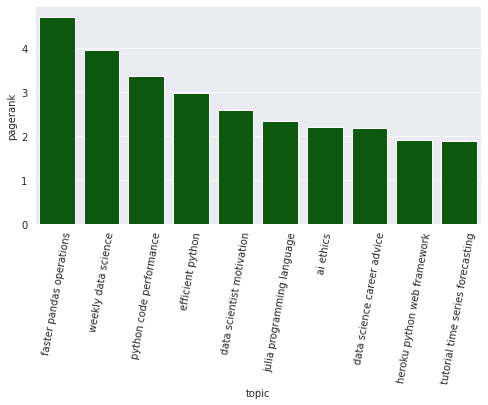

In [68]:
data = read_query("""
MATCH (c:Cluster)
RETURN c.key1 as topic,  c.pagerank_cotopics as pagerank
ORDER BY pagerank DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(8,4))
ax = sns.barplot(x="topic", y="pagerank", data=data, color="darkgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);

In [62]:
# Get statistics on the weight distribution of PageRank
data = read_query("""
CALL gds.pageRank.write('cotopic-network', 
  {writeProperty:'pagerank_cotopics', maxIterations:20, 
  relationshipWeightProperty:'weight'})
YIELD centralityDistribution
""")
data.centralityDistribution[0]

{'p99': 3.9641551971435547,
 'min': 0.2720451354980469,
 'max': 4.729246139526367,
 'mean': 0.9612404616562636,
 'p90': 1.666036605834961,
 'p50': 0.7800121307373047,
 'p999': 4.729246139526367,
 'p95': 2.178403854370117,
 'p75': 1.1363506317138672}

Use the approximate Betweenness centrality to observe the most influential topics over the information flow in the co-topics network.

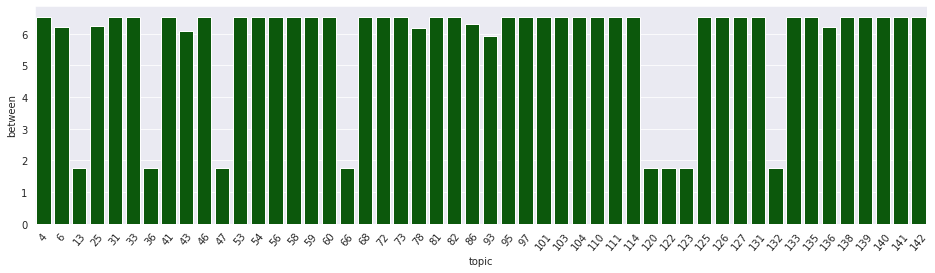

In [69]:
data = read_query("""
CALL gds.betweenness.stream('cotopic-network', 
  {samplingSize:1000})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).topic as topic, score as between
ORDER BY between DESC LIMIT 50
""")

fig, ax = pyplot.subplots(figsize=(16,4))
ax = sns.barplot(x="topic", y="between", data=data, color="darkgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50);

In [70]:
# The betweeness centrality takes only several values
data.between.unique()

array([6.53814847, 6.29744496, 6.23427599, 6.20754553, 6.18170218,
       6.08580111, 5.91509873, 1.76207414])

In [71]:
# The topic with highest betweness centrality score
data.iloc[0]

topic      72.00
between     6.54
Name: 0, dtype: float64

In [72]:
# Take a look at topic 72
data = read_query("""
MATCH (c:Cluster)
WHERE c.topic = 72
RETURN c.key1, c.description1, c.key2, c.description2
""")
data

,c.key1,c.description1,c.key2,c.description2
0,stronger python exploratory data analysis,activity for gaining insight from data,analysis gui,


In [73]:
# Drop the projection
read_query("""
CALL gds.graph.drop('cotopic-network')
""")

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,cotopic-network,neo4j,,-1,143,20033,{'relationshipQuery': 'MATCH (s:Cluster)-[]-()<-[:WROTE]-(a:Author)-[:WROTE]->()-[]-(t:Cluster) RETURN id(s) as s...,0.99,2023-03-05T07:58:44.486698336-06:00,2023-03-05T07:58:45.325633129-06:00,"{'graphProperties': {}, 'relationships': {'__ALL__': {'weight': 'Float (DefaultValue(NaN), TRANSIENT, Aggregation.NO...","{'graphProperties': {}, 'relationships': {'__ALL__': {'properties': {'weight': 'Float (DefaultValue(NaN), TRANSIENT,..."


## Knowledge Graphs Blogs Subgraph

In [75]:
# Create fulltext search index
with driver.session() as session:
    session.run('''CREATE FULLTEXT INDEX searchIndex IF NOT EXISTS FOR (b:Blog) 
                ON EACH [b.title, b.subtitle, b.date];''')

In [15]:
# Find blogs that mention knowledge graphs in title or subtitle

data_kg = read_query("""
CALL db.index.fulltext.queryNodes("searchIndex", "knowledge AND graph*")
YIELD node, score
RETURN node.bid AS bid, node.title AS title, node.subtitle AS subtitle, node.topic as topic, score
""")
data_kg.head()

,bid,title,subtitle,topic,score
0,d510269f5cf0,Probabilistic Reasoning on Knowledge Graphs,KNOWLEDGE GRAPHS & REASONING,41,8.56
1,e6b0a03d373d,Knowledge Graph Embedding — A Simplified Version,An explanation of what knowledge graph embeddings…,41,7.57
2,bce66b377b14,Reconciling Your Data and the World with Knowledge Graphs,A thorough introduction to knowledge graphs,41,7.32
3,bb747b27ff3f,What Is a Relational Knowledge Graph?,Exploring the future of graph databases and knowledge graphs,41,7.29
4,2af83065ade0,Build and Analyze Knowledge Graphs with Diffbot,How to Answer Difficult Questions with Knowledge Graph,41,7.27


In [18]:
# Label the KG blogs

import_query = """

UNWIND $data as row
MERGE (b:Blog {bid: row['bid']})
SET b.subject = row['subject']
"""

import_data = []
session = driver.session()
for i, row in data_kg.iterrows():
    import_data.append({'bid':row['bid'], 
                        'title':row['title'], 
                        'subtitle':row['subtitle'], 
                        'topic': row['topic'],
                        'subject': row['subject']})
    if ((i % 2000) == 0) and (len(import_data) != 0):
        session.run(import_query, {'data':import_data})
        import_data = []

session.run(import_query, {'data':import_data})
session.close()

In [19]:
# Drop the full text search index
read_query("DROP INDEX searchIndex")

""


In [33]:
# Extract the KG_blogs in clusters other than  41
data = read_query("""
MATCH (a:Author)-[]-(b:Blog)-[]-(c:Cluster)
WHERE b.subject CONTAINS 'kno' AND b.topic <> 41
RETURN a.name AS author, b.title AS title, b.date AS date
ORDER BY date DESC
""")
data

,author,title,date
0,ff9d63e09a67,English to Cypher with GPT-3 in Doctor.ai,2022-02-21
1,e0af7616d0c8,The New Benchmark for Question Answering over Knowledge Graphs — QALD-9-Plus,2022-02-18
2,bc73969705af,Explore Better Materials Using Deep Graph Convolutional Networks and Bayesian Optimization,2021-07-31
3,5a96ad8aeac8,Reasoning on Financial Intelligence,2020-09-15
4,47a0ecbd2fbe,We’ve Released a COVID-19 Knowledge Graph,2020-07-14
5,b040ce924438,Creating Knowledge Graphs from Resumes and Traversing them,2020-05-29
6,d1fc6e715513,Knowledge Graphs for Social Good Workshop: Helping the United Nations achieve Sustainable Development Goals,2020-03-10
7,a19a0004db61,How Do Conversational Agents Answer Questions?,2020-01-14
8,629856f2b69b,Named Entity Disambiguation Boosted with Knowledge Graphs,2019-12-18
9,e8ec6fa4d7d4,"The Data Fabric, Containers, Kubernetes, Knowledge-Graphs, and more",2019-06-14
